In [158]:
#import necessary library 
import torch
import torch.nn as nn
import torchvision.models as models
from torch import nn
import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from vqa import VQA
from vqaModel import vqaModel
from vqaDataset import vqaDataset
import json
import pdb
import os
from nltk.tokenize import word_tokenize
import scipy.misc as misc

In [159]:
#Here are all the things you need to change first

#need word_to_ix dictionary to change input question into number
word_to_ix = "/datasets/home/81/081/t2yang/ECE285_final/data/word_to_ix.json"

# change your model here
modelName = "/datasets/home/81/081/t2yang/ECE285_final/code/checkpoint/baseline_ba200_lr0.0003_st200_g0.999_shuffle/ep-1600.pt"

#load dataset, don't forget to change path
dataset = {}
dataset['data_info'] = '/datasets/home/81/081/t2yang/ECE285_final/data/data_prepro.json'
dataset['questions'] = '/datasets/home/81/081/t2yang/ECE285_final/data/data_prepro.h5'
dataset['img_feat'] = '/datasets/ee285f-public/vqa_image_feature/data_img_fc7.h5'

#VQA input image and question
q = "Are there any tree?"
image = '/datasets/home/81/081/t2yang/cat.jpg'

In [160]:
#set VQA model initialize parameter
ques_emb_size = 300
rnn_hidden_size = 512
emb_size = 1024
output_size = 1000
batch_size = 200
[IMG_HEIGHT, IMG_WIDTH] = [224, 224]
with open(word_to_ix) as data_file:
    data = json.load(data_file)


In [161]:
#VGG 19 with fc7
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

net = VGGNet(make_layers(cfg['D'])).cuda()

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


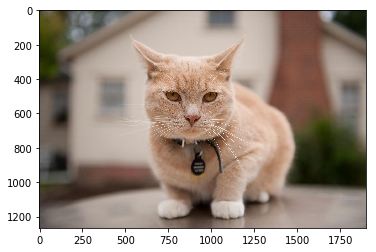

In [162]:
#preprocessing image
def extract_imfeat(img):
    mean = np.array((103.939, 116.779, 123.680), dtype=np.float32)
    I = misc.imresize(img, [IMG_HEIGHT, IMG_WIDTH])-mean
    #I = np.transpose(I, (2, 0, 1))
    I = np.reshape(I,[3,IMG_HEIGHT, IMG_WIDTH])
    I = torch.from_numpy(I)
    I = torch.unsqueeze(I,0)
    I = Variable(I, requires_grad=False).cuda()
    out = net(I)
    return out
#input a picture -> change into torch -> variable
img = plt.imread(image)
plt.imshow(img)
imgfeature = extract_imfeat(img)


In [163]:
#preprocessing question
def prepro_text(question):
    txt = word_tokenize(question.lower())
    ques = [w if data.get(w, len(data)+1) != (len(data)+1) else 'UNK' for w in txt]
    #print(ques)
    label_arrays = np.zeros((1, 26))
    label_length = min(26, len(ques))
    for i in range(2, label_length+1):
        label_arrays[0, -i] = data[ques[-i]]-1
    return label_arrays

ques = torch.from_numpy(prepro_text(q))
ques = ques.type(torch.LongTensor).cuda()
#print(ques)


In [164]:
#initialize a vqaModel we made
dset_test = vqaDataset(dataset, 'test')
test_loader = DataLoader(dataset=dset_test, batch_size=batch_size, shuffle=False)
vqa = vqaModel(
    dset_test.dict_size,
    ques_emb_size,
    rnn_hidden_size,
    dset_test.img_dim,
    emb_size,
    output_size
).cuda()

# restore model parameters
#checkpoint = torch.load(modelName)
#vqa.load_state_dict(checkpoint['vqa_state'])

In [165]:
#writing a evaluate function, input is model, image and question and out put an answer
def evaluateVQA(model, image, question):
    question = Variable(question, requires_grad=False)
    #load model
    check = torch.load(model)
    vqa.load_state_dict(check['vqa_state'])
    #evaluate image and question with model
    output = vqa(image, question)
    outlist = output.cpu().data.numpy()
    #print(outlist)
    #using softmax to turn result into probability
    m = nn.Softmax()
    #outpred shows the probability of 1000 answers
    outpred = m(output)
    #pred is the index of the largest probability
    pred = torch.max(output, dim=1)[1].cpu().data.numpy()
    #print(pred)
    #print(outpred)
    return pred

#test
output = evaluateVQA(modelName, imgfeature, ques)



/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [166]:
#turn the index into answer
outidx = output[0]
print(dset_test.ix_to_ans[str(int(output)+1)])

yes


(536, 860, 3)
<type 'numpy.ndarray'>
()


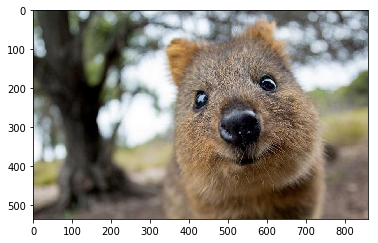

In [126]:
#playground from here 
img = plt.imread('/datasets/home/81/081/t2yang/cute.jpg')
print(img.shape)
print(type(img))
plt.imshow(img)
img_torch = torch.from_numpy(img)
print()

In [ ]:
word_to_ix = "/datasets/home/81/081/t2yang/ECE285_final/data/word_to_ix.json"
with open(word_to_ix) as data_file:
        data = json.load(data_file)
word = "i want a dog ."
wordList = word.split()
print(type(wordList[1]))
for i in range(len(wordList)):
    print(data[wordList[i]])